In [2]:
#libraries
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets

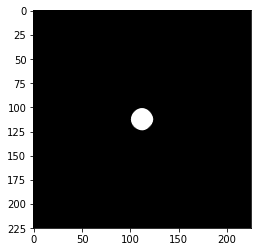

In [4]:
# Load an color image in grayscale
img = cv2.imread('dot2.png',0)
img =255- img 
plt.imshow(img,cmap='gray')
plt.show()

In [60]:
def getRadians(angle):
    return (angle*math.pi)/180
def getBegining(x0,y0,radius,angle_rad):
    beginX = x0 + radius*math.sin(angle_rad)
    beginY= y0 +radius*math.cos(angle_rad)
    return beginX,beginY
def getEndPoint(x0,y0,alpha,angle,radius,subst=0):
    angle_rad= getRadians(angle + 180 + alpha - subst)
    X = x0 + radius*math.sin(angle_rad)
    Y= y0 +radius*math.cos(angle_rad)
    return X,Y

In [61]:
def drawCircle(x0,y0,radius,ax):
    circle=plt.Circle((x0, y0),radius=radius,fill=False)
    ax.add_artist(circle)    

def drawLines(x0,y0,alpha,radius,n,l,ax):
    #Distance between detectors
    if(n>1):
        detectorDelta = float(2*l)/(n-1)
    else:
        detectorDelta=0
        l = 0
    #emmiter
    beginX,beginY = getBegining(x0,y0,radius,getRadians(alpha))
    for i in range(n):
        endX,endY=getEndPoint(x0,y0,alpha,l,radius,i*detectorDelta)
        line = plt.Line2D([beginX,endX],[beginY,endY])
        ax.add_artist(line)
    
def func(n,alpha,l):
    x0 =0.5; y0=0.5 ; radius =0.4
    plt.figure(figsize=(8,8))
    ax=plt.subplot(aspect='equal')
    drawCircle(x0,y0,radius,ax)
    drawLines(x0,y0,alpha,radius,n,l,ax)
    plt.show()
interact(func,n=(1,100),alpha =(0,359),l=(0,179));

interactive(children=(IntSlider(value=50, description='n', min=1), IntSlider(value=179, description='alpha', max=359), IntSlider(value=89, description='l', max=179), Output()), _dom_classes=('widget-interact',))

In [62]:
def getAB(x1,y1,x2,y2):
    a = np.array([[x1,1],[x2,1]])
    b = np.array([y1,y2])
    try:
        x = np.linalg.solve(a, b)
    except np.linalg.LinAlgError:
        return str(x2)
    return x

def getLines(x0,y0,alpha,radius,n,l):
    lines = []
    if(n>1):
        detectorDelta = float(2*l)/(n-1)
    else:
        detectorDelta=0
        l = 0
    bX,bY = getBegining(x0,y0,radius,getRadians(alpha))
    for i in range(n):
        eX,eY=getEndPoint(x0,y0,alpha,l,radius,i*detectorDelta)
        if(eX!=bX and eY!=bY):
            lines.append(getAB(bX,bY,eX,eY))
    return lines
def getSum(img,line):
    xDim = img.shape[0]
    yDim = img.shape[1]
    nPix = 0
    detSum = 0
    if isinstance(line, str):
        xValue = float(line)
        xLeft = math.floor(xValue)
        xRight = math.ceil(xValue)
        if(abs(xValue-xRight)>abs(xValue-xLeft)):
            xValue = xLeft
        else:
            xValue = xRight
        for y in range(yDim):
            detSum += img[xValue,y]
        return detSum / xDim
            
    a = line[0]
    b = line[1]
    if(-1 <= a <= 1):
        for x in range(xDim):
            yValue = a*x + b
            yDown = math.floor(yValue)
            yUp = math.ceil(yValue)
            if(abs(yValue-yUp)>abs(yValue-yDown)):
                if(0<=yDown<yDim):
                    detSum += img[x,yDown]
            else:
                if(0<=yUp<yDim):
                    detSum += img[x,yUp]
        nPix = round(math.sqrt(xDim**2 + (xDim*a)**2), 0)
    else:
        for y in range(yDim):
            xValue = (y - b) / a
            xLeft = math.floor(xValue)
            xRight = math.ceil(xValue)
            if(abs(xValue-xRight)>abs(xValue-xLeft)):
                if(0<=xLeft<xDim):
                    detSum += img[xLeft,y]
            else:
                if(0<=xRight<xDim):
                    detSum += img[xRight,y]
        nPix = round(math.sqrt(yDim ** 2 + (yDim / a) ** 2), 0)
    if(nPix == 0):
        return 0
    else:
        return detSum * nPix

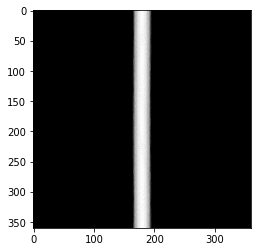

In [63]:
def drawSinogram(n,l_angle):
    sinogram =np.zeros(shape=(360,n))
    x0 = math.floor(img.shape[0]/2)
    y0 = math.floor(img.shape[1]/2)
    radius = (img.shape[0]*math.sqrt(2))/2
    for alpha in range(360):
        lines = getLines(x0,y0,alpha,radius,n,l_angle)
        for y in range(len(lines)):
            sinogram[alpha,y]=getSum(img,lines[y])
    sinogram = np.divide(sinogram, np.amax(sinogram)) * 255
    plt.imshow(sinogram,cmap='gray')
    plt.show()
    return sinogram
sg =drawSinogram(360,100)
#interact(drawSinogram,n=(1,100),l_angle=(0,179));

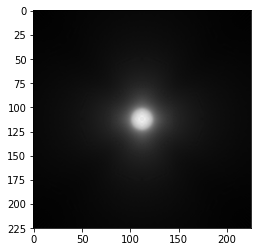

In [64]:
def drawLineOnImage(image,line,value):
    xDim = img.shape[0]
    yDim = img.shape[1]
    a = line[0]
    b = line[1]
    if isinstance(line, str):
        xValue = float(line)
        xLeft = math.floor(xValue)
        xRight = math.ceil(xValue)
        if(abs(xValue-xRight)>abs(xValue-xLeft)):
            xValue = xLeft
        else:
            xValue = xRight
        for y in range(yDim):
            image[xValue,y] += value
        return image
    if(-1 <= a <= 1):
        for x in range(xDim):
            yValue = a*x + b
            yDown = math.floor(yValue)
            yUp = math.ceil(yValue)
            if(abs(yValue-yUp)>abs(yValue-yDown)):
                if(0<=yDown<yDim):
                    image[x,yDown] += value
            else:
                if(0<=yUp<yDim):
                    image[x,yUp] +=value
    else:
        for y in range(yDim):
            xValue = (y - b) / a
            xLeft = math.floor(xValue)
            xRight = math.ceil(xValue)
            if(abs(xValue-xRight)>abs(xValue-xLeft)):
                if(0<=xLeft<xDim):
                    image[xLeft,y] += value
            else:
                if(0<=xRight<xDim):
                    image[xRight,y] += value
        
    return image
def getImageFromSinogram(sinogram,n,l_angle, alpha_max):
    x0 = math.floor(img.shape[0]/2)
    y0 = math.floor(img.shape[1]/2)
    outputImage =np.zeros(shape=(img.shape[0],img.shape[1]))
    radius = (img.shape[0]*math.sqrt(2))/2
    for alpha in range(alpha_max):
        alpha *= int(round(360/alpha_max, 0))
        lines = getLines(x0,y0,alpha,radius,n,l_angle)
        for y in range(len(lines)):
            outputImage = drawLineOnImage(outputImage,lines[y],sinogram[alpha,y])
    outputImage[outputImage<254]=0
    outputImage = np.divide(outputImage,np.amax(outputImage))*255
    outputImage = cv2.GaussianBlur(outputImage,(3,3),0)
    outputImage = np.divide(outputImage,np.amax(outputImage))*255
    plt.subplot(222)
    plt.imshow(outputImage,cmap='gray')
getImageFromSinogram(sg,360,100, 360)
plt.show()

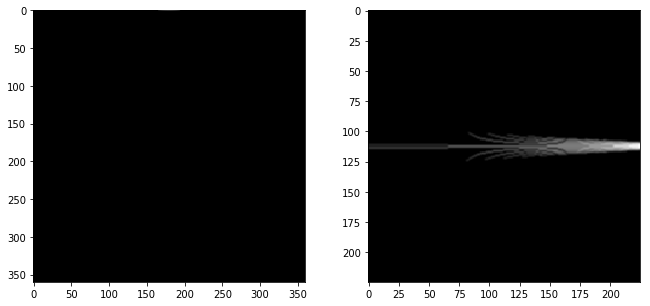

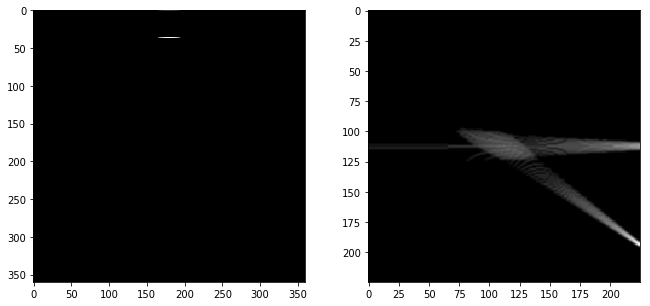

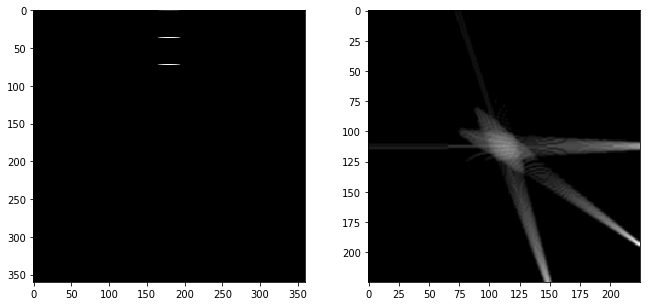

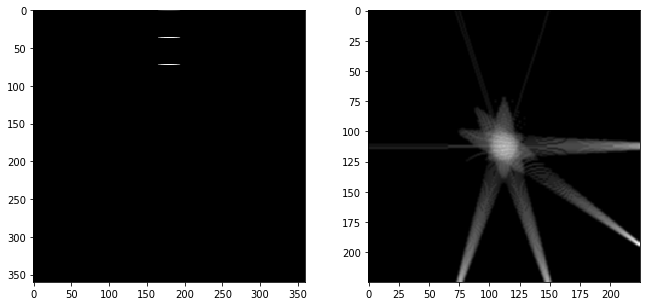

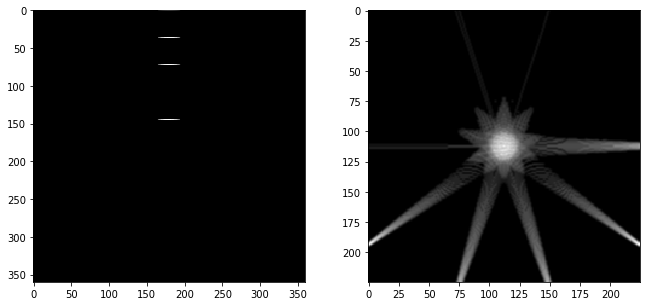

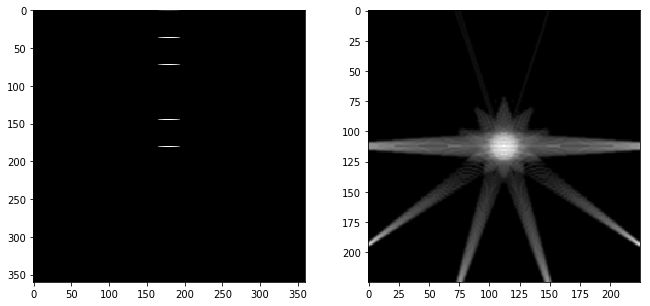

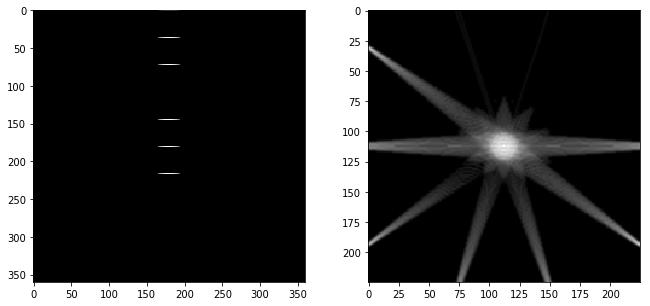

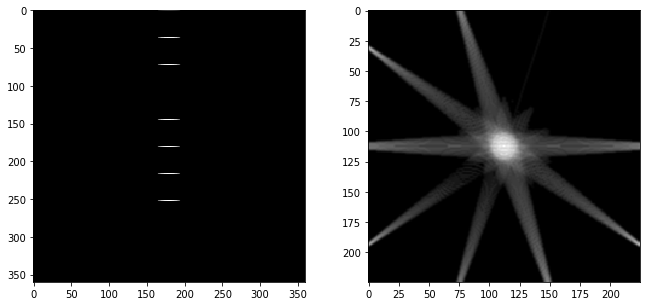

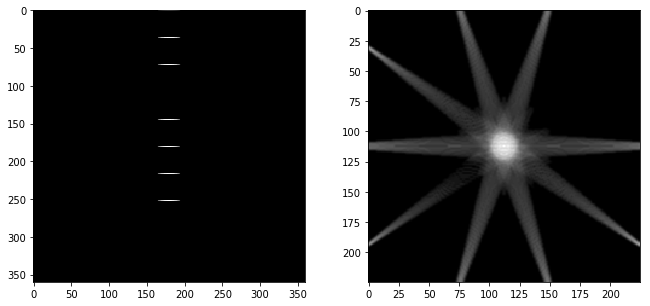

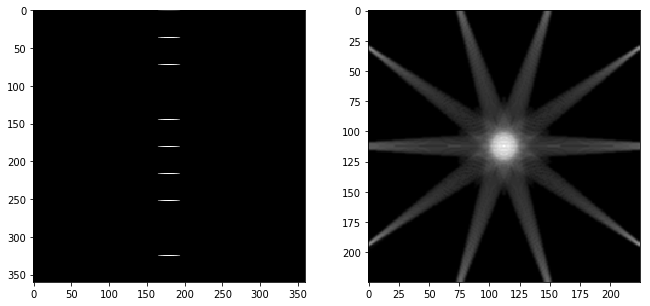

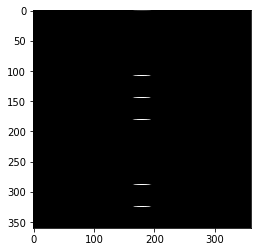

In [57]:
def iterative(n,l_angle):
    alpha_max = 10
    sinogram =np.zeros(shape=(360,n))
    x0 = math.floor(img.shape[0]/2)
    y0 = math.floor(img.shape[1]/2)
    radius = (img.shape[0]*math.sqrt(2))/2
    for alpha in range(alpha_max):
        alpha *= int(round(360/alpha_max, 0))
        lines = getLines(x0,y0,alpha,radius,n,l_angle)
        for y in range(len(lines)):
            sinogram[alpha,y]=getSum(img,lines[y])
        plt.figure(figsize=(11,11))
        plt.subplot(221)
        plt.imshow(sinogram, cmap='gray')
        getImageFromSinogram(np.divide(sinogram, np.amax(sinogram)) * 255, n, l_angle, alpha_max)
        plt.show()
    sinogram = np.divide(sinogram, np.amax(sinogram)) * 255
    plt.imshow(sinogram,cmap='gray')
    plt.show()

iterative(360, 100)